<div style = "font-family:Georgia;
              font-size:2.5vw;
              color:lightblue;
              font-style:bold;
              text-align:center;
              background:url('./iti/Title Background.gif') no-repeat center;
              background-size:cover)">

<br><br>
You Only Look Once (YOLO)
<br><br><br>

</div>

<h1 style = "text-align:left">介绍</h1>

我们在前面的课程中已经了解到，YOLO是一种先进的实时物体检测算法。在这个notebook中，我们将应用YOLO算法来检测图像中的对象。为此，我们提供了一系列用于测试YOLO算法的图像，以下是可以加载的可用图像列表：

* cat.jpg
* city_scene.jpg
* dog.jpg
* dog2.jpg
* eagle.jpg
* food.jpg
* giraffe.jpg
* horses.jpg
* motorbike.jpg
* person.jpg
* surf.jpg
* wine.jpg

这些图像存放于`./images/`文件夹中。我们建议你也使用自己的图像测试YOLO算法。祝你学有所得，学有所乐！

# 导入资源

首先，我们将所需的包加载到Python中。我们将使用OpenCV加载图像，并使用*matplotlib*绘制它们，也会用到包含一些辅助函数的`utils`模块以及*Darknet*的修改版本。YOLO使用的*Darknet*，是一个由YOLO的创建者编写的开源深度神经网络框架。此notebook中使用的*Darknet*版本已经过修改，可以在PyTorch 0.4中使用，并且已简化，因为我们不会进行任何训练。但是，我们将使用一组预训练的权重，这些权重是已经在Common Objects in Context (COCO) 数据库中被训练过。有关*Darknet*的更多信息，请访问<a href="https://pjreddie.com/darknet/">Darknet</a>网站。

In [1]:
import cv2
import matplotlib.pyplot as plt

from utils import *
from darknet import Darknet

# 设置神经网络

我们将使用最新版本的YOLO，即YOLOv3。我们已经下载了`yolov3.cfg`文件，其中包含YOLOv3使用的网络架构，该网络架构存放在`/cfg/`文件夹中。同样，我们把包含预训练权重的`yolov3.weights`文件放在了`/weights/`目录中。另外，`/data/`目录中包含`coco.names`文件，而该文件包含权重训练中要检测的80个对象类的列表。

在下面的代码中，首先要规定包含神经网络架构文件、预训练的权重以及对象类的位置。然后就要使用*Darknet* 设置神经网络，具体要使用`cfg_file`中指定的网络架构。然后，使用`.load_weights()`方法将我们预训练的权重集加载到模型中。最后，使用`utils`模块中的`load_class_names()`函数来加载80个对象类。

In [3]:
# Set the location and name of the cfg file
cfg_file = './cfg/yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = './weights/yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = 'data/coco.names'

# Load the network architecture
m = Darknet(cfg_file)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

# 观察该神经网络

现在已经设置了神经网络，可以看到它的样子了。我们可以使用`.print_network()`函数输出该网络。

In [4]:
# Print the neural network used in YOLOv3
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

可以看到，YOLOv3使用的神经网络主要由卷积层组成，有一些快捷连接层和上采样层。有关此网络的完整说明，请参阅这篇 <a href="https://pjreddie.com/media/files/papers/YOLOv3.pdf">YOLOv3 论文</a>。

# 加载并调整图像大小

在下面的代码中，我们使用OpenCV的`cv2.imread()`函数来加载我们的图像。因为，此函数将图像加载为BGR，而我们要将图像转换为RGB，以便可以使用正确的颜色显示它们。

正如我们在前一个单元格中看到的那样，该神经网络第一层的输入大小为416 x 416 x 3。由于图像大小不同，我们必须调整图像大小，使其与网络中第一层的输入大小兼容。在下面的代码中，我们使用OpenCV的`cv2.resize()`函数调整图像大小。然后，绘制原始图像和调整大小后的图像。

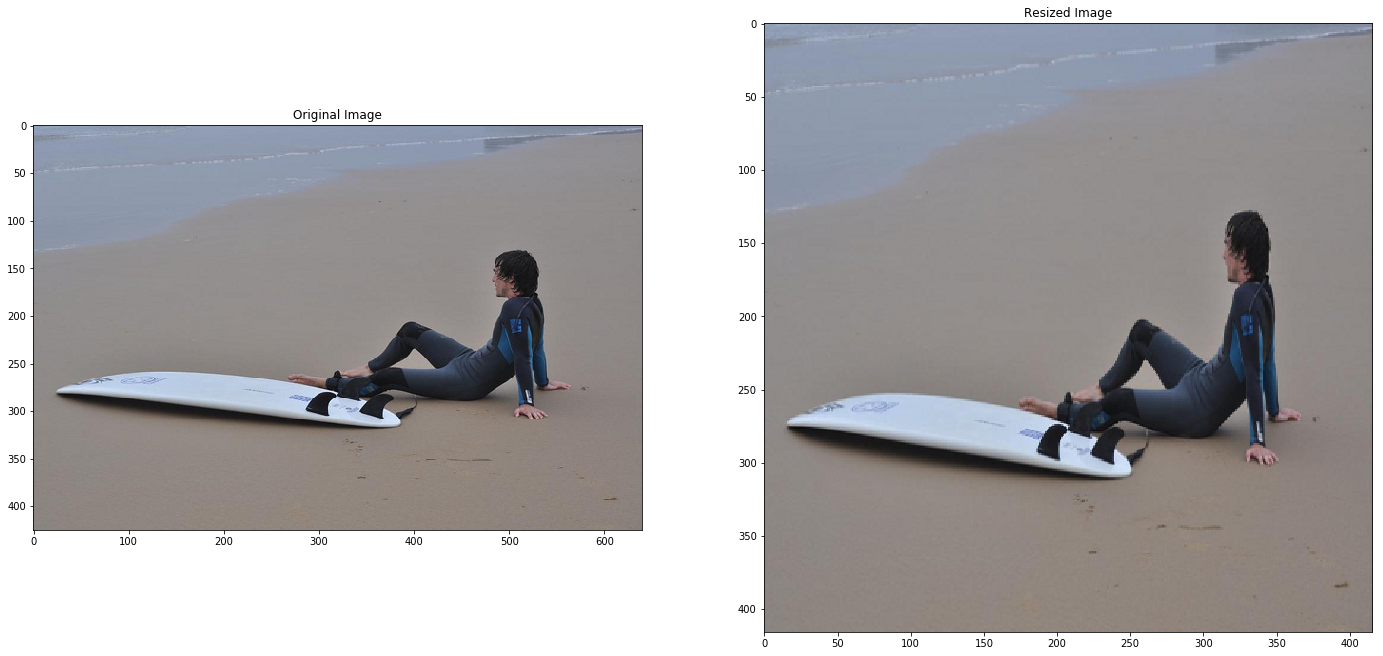

In [7]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('./images/surf.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

# 设置非极大抑制阈值

我们在前面的课程中已经了解到，YOLO使用**非极大值抑制（NMS）**来保留最佳边界框。NMS的第一步是删除检测概率小于给定NMS阈值的所有预测边界框。在下面的代码中，我们将此NMS阈值设置为0.6。这意味着将删除检测概率小于0.6的所有预测边界框。

In [8]:
# Set the NMS threshold
nms_thresh = 0.6

# 设置交并比（IOU）阈值

在删除所有具有低检测概率的预测边界框之后，NMS中的第二步是选择具有最高检测概率的边界框，并消除其**交并比（IOU）**值高于给定IOU阈值的所有边界框。 在下面的代码中，我们将此IOU阈值设置为`0.4`。这就是说，相对于最佳边界框来说， IOU值大于0.4的所有预测边界框将会被删除。

在`utils`模块中，你会找到一个执行非极大抑制的第二步的`nms`函数，以及计算两个给定边界框交并比值的`boxes_iou`函数。我们建议你查看这些函数，了解它们的工作原理。

In [10]:
# Set the IOU threshold
iou_thresh = 0.4

# 物体检测

图像被加载并调整大小，并且选定了`nms_thresh`和`iou_thresh`的参数之后，我们就可以使用YOLO算法来检测图像中的对象。我们要使用`utils`模块中的`detect_objects(m, resized_image, iou_thresh, nms_thresh)`函数来检测对象。此函数会接收*Darknet*返回的模型`m`、调整大小的图像以及NMS与IOU阈值作为输入，并返回检测到的对象的边界框。

每个边界框包含7个参数：边界框中心的坐标 *(x, y)*、边界框的宽度*w*和高度*h*、置信度检测级别、对象类概率以及对象类id。`detect_objects()`函数还会输出YOLO算法用于检测图像中的对象和检测到的对象数所花费的时间。由于我们是在CPU上运行该算法，因此检测到图像中的对象大约需要2秒钟，但是，如果使用GPU，它将运行得更快。

获得YOLO检测到的对象的边界框之后，就可以输出检测到的对象的类及其对应的对象类概率。为此，我们要用到`utils`模块中的`print_objects()`函数。

 最后，我们要使用`plot_boxes()`函数绘制YOLO在我们的图像中检测到的边界框和相应的对象类标签。如果将 `plot_labels`标记设置为`False`，则将显示没有标签的边界框。如果`nms_thresh` 值太低，可以更容易地查看边界框。 `plot_boxes()`函数会使用相同的颜色绘制同一对象类的边界框。但是，如果希望所有边界框都是相同的颜色，则可以使用`color` 关键字设置所需的颜色。例如，如果你希望所有边界框都是红色的，则可以使用：

`plot_boxes(original_image, boxes, class_names, plot_labels = True, color = (1,0,0))` 

在这里，我们建议你更改`iou_thresh` 和 `nms_thresh` 参数，以便了解它们是如何影响YOLO检测算法。`iou_thresh = 0.4` 和 `nms_thresh = 0.6` 的默认值可以很好地检测不同类型图像中的对象。在下面的单元格中，我们重复了之前使用的一些代码，防止你要更改`iou_thresh` 和 `nms_thresh`参数或图像时向上滚动。最后，祝学有所得，学有所乐！

In [ ]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('./images/surf.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)